In [4]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)


# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os


# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

from matplotlib import font_manager, rc
import platform


path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)


mpl.rcParams['axes.unicode_minus'] = False


# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3


import seaborn as sns

import scipy as sp
from scipy import stats


# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"


# 노트북 실행 결과를 동일하게 유지하기 위해
# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경되면
# 훈련용 데이터가 자주 변ㅕ되면 결국 모든 데터를 가지고 모델을 생성하는 결과
# Outfit을 만드는 효과를 가져옴.
np.random.seed(42)

# MNIST data

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist)

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object), 'frame': None, 'categories': {}, 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', '

In [6]:
X, y = mnist['data'], mnist['target']

# 데이터는 784픽셀을 가진 흑백 이미지로 실제 크기는 28 * 28
# 각 픽셀은 0 ~ 255 까지의 값을 가짐.
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


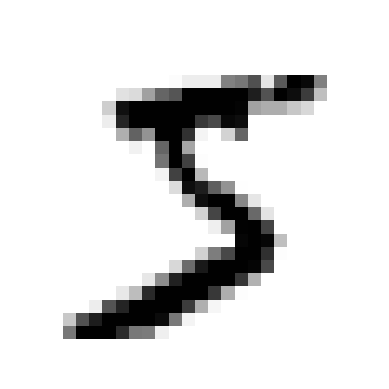

In [7]:
# 하나의 이미지 출력
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

plt.savefig('some_digit_plot')

그림 저장: more_digits_plot


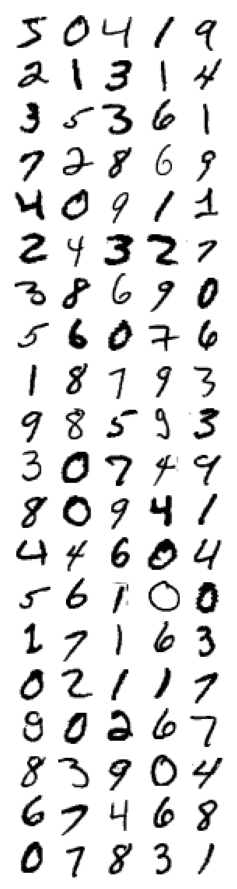

In [10]:
# 여러 개의 이미지를 출력하기 위한 함수
# 첫 번째 매개변수는 images
# 두 번째 매개변수는 하나의 행에 출력할 이미지의 수 : 기본값은 10
# 세 번재 매개변수는 옵션으로 딕셔너리를 설정함
# 여러 개의 옵션을 설정해야 하는 경우 각 매개변수를 나열하는 것은 함수의 가독성을 떨어뜨림.
# 이런 경우 매개변수를 하나로 묶음 -> dict(**이 붙음)나 class.
# 생략이 많은 경우 dict, 그렇지 않은 경우 class.
# 시각화 라이브러리는 옵션이 많음 -> dict.

def plot_digits(instance, images_per_row = 10, **options):
    # 이미지 크기를 변수로 생성
    size = 28
    # 행에 출력할 이미지의 개수를 설정
    images_per_row = min(len(instance), images_per_row)

    # 이미지 크기 설정
    images = [instance.reshape(size, size) for instance in instance]

    # 행의 크기를 출력
    n_rows = (len(instance)-1) // images_per_row + 1

    # 이미지들을 저장할 리스트
    row_images = []
    n_empty = n_rows * images_per_row - len(instance)

    # 0으로 이루어진 행렬을 만들어서 row_images에 저장

    images.append(np.zeros(size * size * n_empty))

    # 행 단위로 순회하면 실제 이미지를 추가
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))

    image = np.concatenate(row_images, axis=0)

    #이미지 출력
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

     
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
save_fig("more_digits_plot")
plt.show()

In [12]:
# 타겟의 자료형 확인
print(type(y[0]))

# 범주형 데이터의 자료형은 정수를 권장함.
# 타겟의 자료형 변경

# np.int -> numpy 버전이 변경되면서 없어짐.
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>
